# Imports

In [1]:
# System and OS
import sys,os

# Data types
import datetime

# Basic numeric/data analysis and viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Advanced data analysis
import sklearn as sk


# Constants & Params

In [2]:
# Paths for data and visualization
DATA_PATH = '../data'
VIZ_PATH = '../viz'

# Paths for data Hopkins Y INS
HOPKINS_PATH = 'hopkins'
INS_PATH = 'ins'
OWID_PATH = 'owid'
# Fonts for matplotlib
LARGE_SIZE = 20
SMALL_SIZE = 17
SSSMALL_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

# Latex fonts
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Countries For this study
countries = ['BRA','CHL','COL','MEX','PER','USA','ECU','ARG','DEU','ITA']
# Color Scheme
country_palette = \
{'Brazil':'lime',
 'Chile':'navy',
 'Mexico':'maroon',
 'Peru':'darkgoldenrod',
 'United States':'orangered',
 'Ecuador':'darkgreen',
 'Argentina':'lightseagreen',
 'Germany':'dimgrey',
 'Italy':'blueviolet',
 'Colombia':'black'}


# Useful Functions

In [3]:
@np.vectorize
def str_to_date(date_str:str):
    """
    Converts a string to datetime.date in the format 'm/d/yy'

    Keyword arguments:
    date_str -- The date in string format
    
    Returns:
    date_dt -- The date in datetime.date data type
    """
    date_split = date_str.split('/')
    return datetime.date( day=int(date_split[1])
                         ,month=int(date_split[0])
                         ,year=int('20'+date_split[2]))

def pivot_time_series( df:pd.DataFrame
                      ,val_name:str = 'Value'):
    """
    Pivot dataframe time series into a column of dates and values

    Keyword arguments:
    df -- The dataframe to pivot
    val_name -- The names of the values (default 'value')
    
    Returns:
    df -- The pivoted dataframe
    """
    
    # Retrieve date columns
    date_cols = [col for col in df.columns if col.count('/')==2]
    # Indentifier columns
    id_cols = [col for col in df.columns if col not in date_cols]
    
    # Performs a pivot
    df = df.melt(id_vars = id_cols, 
                 value_vars = date_cols,
                 var_name = 'Date',
                 value_name = val_name)
    
    df = df[df['Value'] > 0]
    # Converts to datetime
    df['Date'] = df['Date'].map(str_to_date)
    
    # Calculates
    df['Days Since First Case'] = df.groupby(['ISO 3166-1 Alpha 3-Codes'])[['Date']].transform('min')
    df['Days Since First Case'] = (df['Date'] - df['Days Since First Case']).map(lambda x:x.days)

        # Changes column name
    df = df.rename(columns={'ISO 3166-1 Alpha 3-Codes':'Country Code'})
    
    
    # Returns da

# Data Loading & Structure [Testing Our world in Data]
Data obtained on https://github.com/owid/covid-19-data/tree/master/public/data/

In [4]:
# Confirmed_cases
owid = pd.read_csv(f'{DATA_PATH}/{OWID_PATH}/'+
                          f'owid-covid-data.csv',
                          skiprows=0)

# Calculates the positive case to Test ratio for each country/date
owid['Ratio de Positivos por Test'] = 100*owid['total_cases']/owid['total_tests']

# Parse Dates to datetime format
owid['date'] = owid['date'].map(lambda x: datetime.date(*[int(y) for y in x.split('-')]))

# Filter countries
owid = owid[owid['iso_code'].isin(countries)]

# Removes NaN and 0 values on Total cases values
owid = owid[owid['total_cases']>0]

# Calculates
owid['Days Since First Case'] = owid.groupby(['iso_code'])[['date']].transform('min')
owid['Days Since First Case'] = (owid['date'] - owid['Days Since First Case']).map(lambda x:x.days)

# Define pais
owid['Pais'] = owid['location']

In [5]:
owid.loc[(owid['iso_code']=='USA')&(owid['total_deaths']>0),['date','total_deaths','total_cases']]

,date,total_deaths,total_cases
21095,2020-03-01,1,69
21096,2020-03-02,2,89
21097,2020-03-03,6,103
21098,2020-03-04,9,125
21099,2020-03-05,11,159
...,...,...,...
21188,2020-06-02,105147,1811277
21189,2020-06-03,106181,1831821
21190,2020-06-04,107175,1851520
21191,2020-06-05,108211,1872660


In [6]:
owid.loc[(owid['iso_code']=='CHL')&(owid['total_deaths']>0),['date','new_tests_per_thousand']]
#owid['total_tests_per_thousand']

,date,new_tests_per_thousand
4147,2020-03-23,NaN
4148,2020-03-24,NaN
4149,2020-03-25,NaN
4150,2020-03-26,NaN
4151,2020-03-27,NaN
...,...,...
4218,2020-06-02,0.710
4219,2020-06-03,0.813
4220,2020-06-04,0.949
4221,2020-06-05,NaN


# Differentiation to obtain multiplication times
In the context of cumulative counting functions, the slope of the time series in logarithmic scale is directly related to the multiplication period. This is easy to verify assuming local lineal behavior of the logarithmic function, which is equivalent to local exponential behavior of its natural counterpart:

$$Ln(y)=mt + b \rightarrow y = y_0 e^{mt}$$
$$\frac{d Ln(y)}{dt} = m $$

We can relate this slope $m$ to the specific doubling time $\tau$:
$$y(t+\tau) = 2y(t)$$
$$y_0 e^{m(t+\tau)} = 2 y_0 e^{mt}$$
$$e^{m\tau} = 2$$
$$\tau = \frac{Ln(2)}{m}$$

In [7]:
# Defines a function that returns the doubling time 
# According to a cumulative reference col 
def get_doubling_time(df, ref_col):
    
    # Sorts values by dates
    df = df.sort_values(by='date')
    
    # Gets nonzero values mask
    non_zero_mask = df[ref_col]!=0
    
    # Gets the derivative (second order error derivative) mid point rule
    derivative_log = 0.5*((df.loc[non_zero_mask,ref_col].values[2:]-
                           df.loc[non_zero_mask,ref_col].values[:-2])/
                          df.loc[non_zero_mask,ref_col].values[1:-1])  
    
    # Asigns derivative to a new column
    derivatives_log = np.zeros(len(df.index))*np.nan
    derivatives_log[non_zero_mask] = np.array([np.nan]+list(derivative_log)+[np.nan])
    df['Derivative'] = derivatives_log
    
    # Calculates doubling times
    df['Doubling Time'] = np.nan
    df.loc[~df['Derivative'].isna(),'Doubling Time'] = np.log(2)/df.loc[df['Derivative']!=0,'Derivative']

    # Calculates doubling times
    df['Doubling Time Smoothened'] = np.nan
    # Smoothen signals with savgol filter
    from scipy.signal import savgol_filter
    y = savgol_filter(df.loc[~df['Doubling Time'].isna(),'Doubling Time'].values,9,1)
    df.loc[~df['Doubling Time'].isna(),'Doubling Time Smoothened'] = y
    
    # Calculates doubling times    
    df['Derivative'] = 100*df['Derivative']
    
    # Returns df
    return df


In [8]:
# Gets duplication times for each country

# Doubling times for deaths
total_dfs = []
for country in countries:
    df_app = get_doubling_time(owid[owid['iso_code'] == country],'total_cases')
    df_app = df_app[[ 'iso_code'
                     ,'Pais'
                     ,'date'
                     ,'total_cases'
                     ,'total_deaths'
                     ,'Doubling Time'
                     ,'Doubling Time Smoothened'
                     ,'Days Since First Case']]
    total_dfs.append(df_app)
doubling_time_dfs = pd.concat(total_dfs)

total_dfs = []
for country in countries:
    df_app = get_doubling_time(owid[owid['iso_code'] == country],'total_deaths')
    df_app = df_app[[ 'iso_code'
                     ,'Pais'
                     ,'date'
                     ,'total_cases'
                     ,'total_deaths'
                     ,'Doubling Time'
                     ,'Doubling Time Smoothened'
                     ,'Days Since First Case']]
    total_dfs.append(df_app)
doubling_time_deaths_dfs = pd.concat(total_dfs)

In [9]:
owid

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,Ratio de Positivos por Test,Days Since First Case,Pais
706,ARG,South America,Argentina,2020-03-04,1,1,0,0,0.022,0.022,...,0.6,191.032,5.50,16.2,27.7,NaN,5.00,NaN,0,Argentina
707,ARG,South America,Argentina,2020-03-06,2,1,0,0,0.044,0.022,...,0.6,191.032,5.50,16.2,27.7,NaN,5.00,NaN,2,Argentina
708,ARG,South America,Argentina,2020-03-07,8,6,0,0,0.177,0.133,...,0.6,191.032,5.50,16.2,27.7,NaN,5.00,NaN,3,Argentina
709,ARG,South America,Argentina,2020-03-08,9,1,1,1,0.199,0.022,...,0.6,191.032,5.50,16.2,27.7,NaN,5.00,NaN,4,Argentina
710,ARG,South America,Argentina,2020-03-09,12,3,1,0,0.266,0.066,...,0.6,191.032,5.50,16.2,27.7,NaN,5.00,NaN,5,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21188,USA,North America,United States,2020-06-02,1811277,21086,105147,764,5472.092,63.703,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,9.579213,133,United States
21189,USA,North America,United States,2020-06-03,1831821,20544,106181,1034,5534.158,62.066,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,9.451009,134,United States
21190,USA,North America,United States,2020-06-04,1851520,19699,107175,994,5593.671,59.513,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,9.345804,135,United States
21191,USA,North America,United States,2020-06-05,1872660,21140,108211,1036,5657.538,63.867,...,1.2,151.089,10.79,19.1,24.6,NaN,2.77,NaN,136,United States


/home/jesus_prada/anaconda3/envs/ml_rappi/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


    Italy
Name: 6, dtype: object


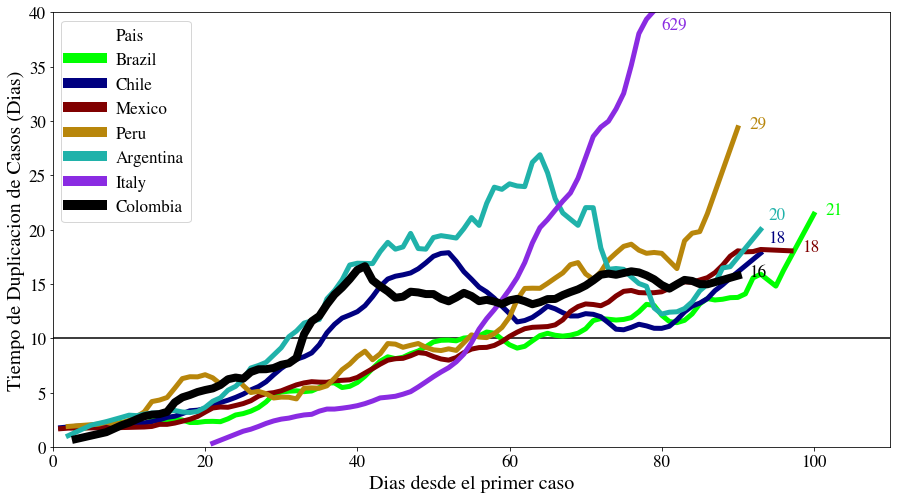

In [10]:
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
sns.set_palette('bright')

# Plots duplication times accross different countries
def plot_dup_times1(countries_reg,fig_name,data,which='cases'):
    # Figure
    fig = plt.figure(figsize=(15,8))

    # Plots curves
    sns.lineplot( x='Days Since First Case'
                 ,y='Doubling Time Smoothened'
                 ,data=data[data['iso_code'].isin(countries_reg)&(owid['Pais']!='Colombia')]
                 ,hue='Pais'
                 ,palette = country_palette
                 ,linewidth=5)
    sns.lineplot( x='Days Since First Case'
                 ,y='Doubling Time Smoothened'
                 ,data=data[data['Pais']=='Colombia']
                 ,color='black'
                 ,label = 'Colombia'
                 ,linewidth=8)    
    # H line for reference
    plt.hlines(10,data['Days Since First Case'].min(),data['Days Since First Case'].max())

    # Customize Axes lims
    #plt.xlim(datetime.date(2020,3,1),data['Days Since First Case'].max())
    # Ticks rotation
    #plt.xticks(rotation=15)
    # Integer ticks
    #plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    # Custom ticks for x axis
    #plt.gca().xaxis.set_major_locator(mdates.weekLocator())
    
    max_y = 40 
    
    data = data.sort_values(by='Days Since First Case')
    data_last = data.groupby(['Pais']).agg(['last']).reset_index()
    for i, point in data_last.iterrows():
        if (point['iso_code'].values[0] in countries_reg ):
            #print(point['Days Since First Case'].values[0],
            #      point['Doubling Time Smoothened'].values[0],
            #      '%.2f' % point['Doubling Time Smoothened'].values[0])
            if(point['Doubling Time Smoothened'].values[0] > max_y):
                print(point['Pais'])
                plt.gca().text(80, 
                        max_y-1.5,
                        str('%.0f' % point['Doubling Time Smoothened'].values[0])
                        ,color=country_palette[point['Pais'].values[0]])
            elif(point['iso_code'].values[0]  in ['ARG','CHL']):
                plt.gca().text(point['Days Since First Case'].values[0],
                        point['Doubling Time Smoothened'].values[0]+1,
                        str('%.0f' % point['Doubling Time Smoothened'].values[0]),
                            color=country_palette[point['Pais'].values[0]]  )
            else:
                plt.gca().text(point['Days Since First Case'].values[0]+0.5,
                        point['Doubling Time Smoothened'].values[0],
                        str('%.0f' % point['Doubling Time Smoothened'].values[0]),
                            color=country_palette[point['Pais'].values[0]]  )

    # Axes labels
    plt.xlabel('Dias desde el primer caso')
    plt.ylabel('Tiempo de Duplicacion de Casos (Dias)')
    
    plt.ylim(0,40)
    plt.xlim(0,110)
    # Plots legend
    # gets legend
    leg = plt.gca().legend()
    # Line thicknes in legend
    for line in leg.get_lines():
        line.set_linewidth(10)
    
    # Save fig
    plt.savefig(f'{VIZ_PATH}/{fig_name}.png')

# Countries
#countries_reg = ['Mexico','Colombia','Brazil','Chile','Peru']
#plot_dup_times(countries_reg,'Tiempo de Duplicacion LATAM',doubling_time_dfs)
# Countries
#countries_reg = [ 'Germany'
#                 ,'United Kingdom'
#                 ,'Italy'
#                 ,'France'
#                 ,'Spain'
#                 ,'US'
#                 ,'Japan']
                 #,'Korea, South']
#plot_dup_times(countries_reg,'Tiempo de Duplicacion Mundo',doubling_time_dfs)
plot_dup_times1(['MEX','COL','BRA','CHL','PER','ARG','ITA'],'Tiempo de Duplicacion Casos Final',doubling_time_dfs)

/home/jesus_prada/anaconda3/envs/ml_rappi/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


    Italy
Name: 6, dtype: object


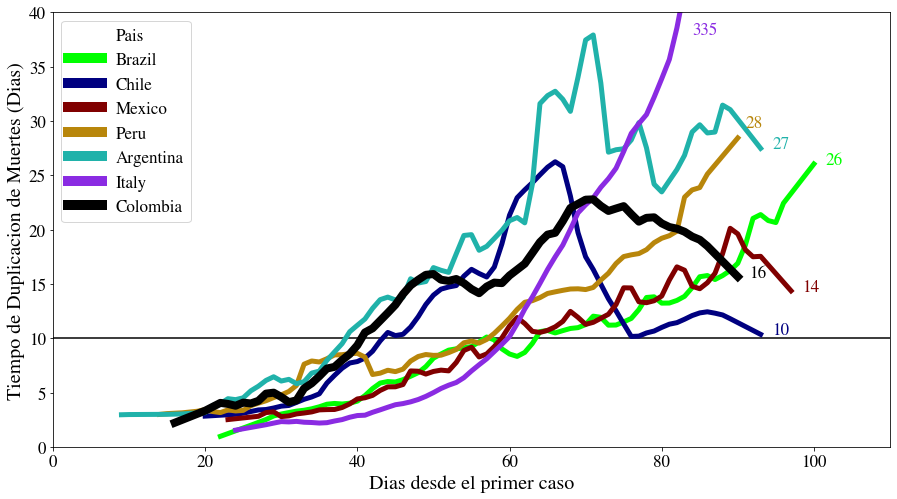

In [11]:
# Plots duplication times accross different countries
def plot_dup_times2(countries_reg,fig_name,data,which='cases'):
    # Figure
    fig = plt.figure(figsize=(15,8))

    # Plots curves
    sns.lineplot( x='Days Since First Case'
                 ,y='Doubling Time Smoothened'
                 ,data=data[data['iso_code'].isin(countries_reg)&(owid['Pais']!='Colombia')]
                 ,hue='Pais'
                 ,palette = country_palette
                 ,linewidth=5)
    sns.lineplot( x='Days Since First Case'
                 ,y='Doubling Time Smoothened'
                 ,data=data[data['Pais']=='Colombia']
                 ,color='black'
                 ,label = 'Colombia'
                 ,linewidth=8)    
    # H line for reference
    plt.hlines(10,data['Days Since First Case'].min(),data['Days Since First Case'].max())

    # Customize Axes lims
    #plt.xlim(datetime.date(2020,3,1),data['Days Since First Case'].max())
    # Ticks rotation
    #plt.xticks(rotation=15)
    # Integer ticks
    #plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    # Custom ticks for x axis
    #plt.gca().xaxis.set_major_locator(mdates.weekLocator())
    
    max_y = 40 
    
    data = data.sort_values(by='Days Since First Case')
    data_last = data.groupby(['Pais']).agg(['last']).reset_index()
    for i, point in data_last.iterrows():
        if (point['iso_code'].values[0] in countries_reg ):
            #print(point['Days Since First Case'].values[0],
            #      point['Doubling Time Smoothened'].values[0],
            #      '%.2f' % point['Doubling Time Smoothened'].values[0])
            if(point['Doubling Time Smoothened'].values[0] > max_y):
                print(point['Pais'])
                plt.gca().text(84, 
                        max_y-2,
                        str('%.0f' % point['Doubling Time Smoothened'].values[0])
                        ,color=country_palette[point['Pais'].values[0]])
            elif(point['iso_code'].values[0]  in ['PER']):
                plt.gca().text(point['Days Since First Case'].values[0],
                        point['Doubling Time Smoothened'].values[0]+1,
                        str('%.0f' % point['Doubling Time Smoothened'].values[0]),
                            color=country_palette[point['Pais'].values[0]]  )                
            else:
                plt.gca().text(point['Days Since First Case'].values[0]+0.5,
                        point['Doubling Time Smoothened'].values[0],
                        str('%.0f' % point['Doubling Time Smoothened'].values[0]),
                            color=country_palette[point['Pais'].values[0]]  )

    # Axes labels
    plt.xlabel('Dias desde el primer caso')
    plt.ylabel('Tiempo de Duplicacion de Muertes (Dias)')
    
    plt.ylim(0,40)
    plt.xlim(0,110)
    # Plots legend
    # gets legend
    leg = plt.gca().legend()
    # Line thicknes in legend
    for line in leg.get_lines():
        line.set_linewidth(10)
    
    # Save fig
    plt.savefig(f'{VIZ_PATH}/{fig_name}.png')
plot_dup_times2(['MEX','COL','BRA','CHL','PER','ARG','ITA'],'Tiempo de Duplicacion Muertes Final',doubling_time_deaths_dfs)

# Total Cases (Comparable)

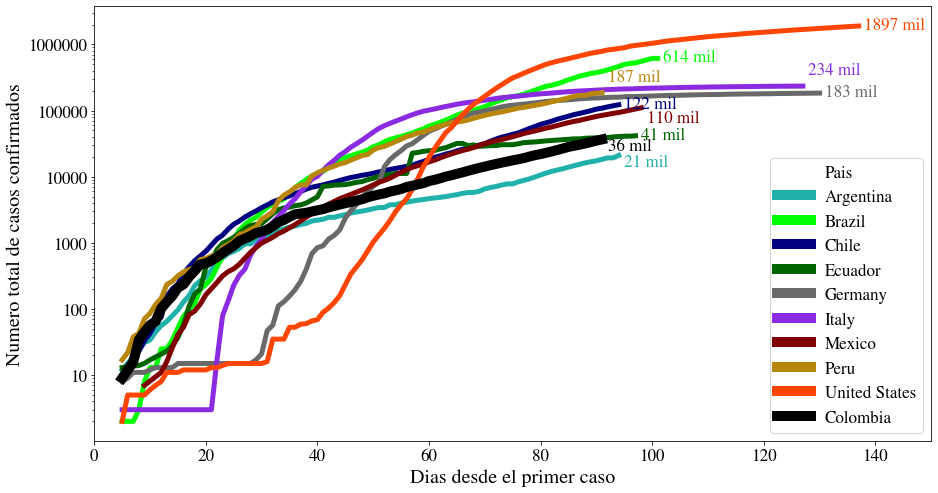

In [12]:
from matplotlib import ticker
sns.set_palette('bright')
#sns.set_palette(sns.color_palette('Accent_r'))

# Figure
fig = plt.figure(figsize=(15,8))
ax = plt.gca()

# Cols to plot
x_col = 'Days Since First Case'
y_col = 'total_cases'

# Plots curves

sns.lineplot( x='Days Since First Case'
             ,y='total_cases'
             ,data=owid[(owid[x_col]>=5)&(owid['Pais']!='Colombia')]
             ,hue='Pais'
             ,palette=country_palette
             ,linewidth=5)
sns.lineplot( x='Days Since First Case'
             ,y='total_cases'
             ,data=owid[(owid[x_col]>=5)&(owid['Pais']=='Colombia')]
             ,color = 'black'
             ,label='Colombia'
             ,linewidth=10)
# Log scale
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))


data = owid.sort_values(by='Days Since First Case')
data_last = data.groupby(['Pais']).agg(['last']).reset_index()
for i, point in data_last.iterrows():
    if (point['iso_code'].values[0] in countries ):
        #print(point['Days Since First Case'].values[0],
        #      point['Doubling Time Smoothened'].values[0],
        #      '%.2f' % point['Doubling Time Smoothened'].values[0])
        if point['Pais'].values[0] in ['Peru']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_cases'].values[0]*1.5,
                        str('%d' % int(point['total_cases'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )        
            
        elif point['Pais'].values[0] in ['Italy']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_cases'].values[0]*1.5,
                        str('%d' % int(point['total_cases'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )   
        elif point['Pais'].values[0] in ['Mexico']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_cases'].values[0]*0.6,
                        str('%d' % int(point['total_cases'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )   
        elif point['Pais'].values[0] in ['Colombia']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_cases'].values[0]*0.7,
                        str('%d' % int(point['total_cases'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )   
        elif point['Pais'].values[0] in ['Argentina']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_cases'].values[0]*0.7,
                        str('%d' % int(point['total_cases'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )              
        else:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_cases'].values[0]*(1-(10000-np.log(point['total_cases'].values[0]))/100000),
                        str('%d' % int(point['total_cases'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )


# Plots legend
plt.legend(loc='best')

# gets legend
leg = plt.gca().legend()
# Line thicknes in legend
for line in leg.get_lines():
    line.set_linewidth(10)

plt.xlim(0,150)
# Axes labels
plt.xlabel('Dias desde el primer caso')
plt.ylabel('Numero total de casos confirmados')

# Save fig
plt.savefig(f'{VIZ_PATH}/Casos_totales.png')

#plt.ylim(0,200000)

# Total Deaths

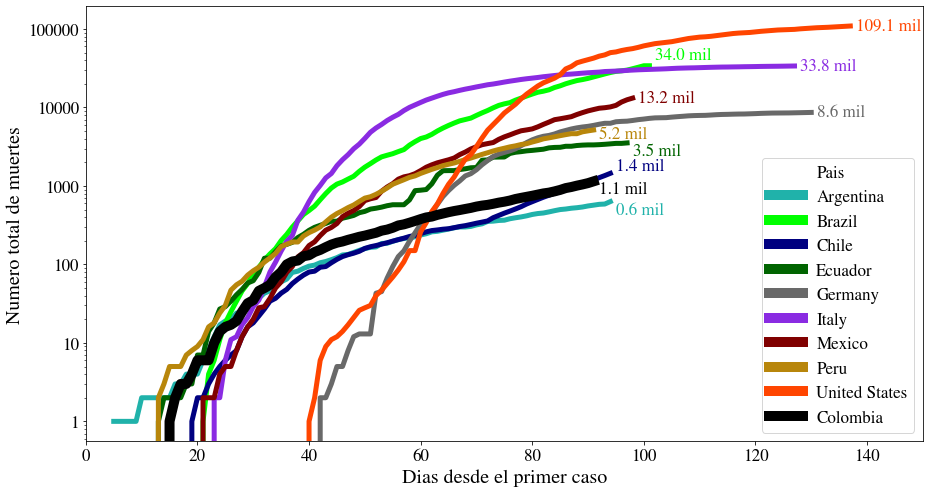

In [13]:
from matplotlib import ticker
#sns.set_palette(sns.color_palette('Accent_r'))

# Figure
fig = plt.figure(figsize=(15,8))
ax = plt.gca()

# Cols to plot

# Plots curves
sns.lineplot( x='Days Since First Case'
             ,y='total_deaths'
             ,data=owid[(owid[x_col]>=5)&(owid['Pais']!='Colombia')]
             ,hue='Pais'
             ,palette=country_palette
             ,linewidth=5)
sns.lineplot( x='Days Since First Case'
             ,y='total_deaths'
             ,data=owid[(owid[x_col]>=5)&(owid['Pais']=='Colombia')]
             ,label='Colombia'
             ,color='black'
             ,linewidth=10)

# Log scale
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))


data = owid.sort_values(by='Days Since First Case')
data_last = data.groupby(['Pais']).agg(['last']).reset_index()
for i, point in data_last.iterrows():
    if (point['iso_code'].values[0] in countries ):
        #print(point['Days Since First Case'].values[0],
        #      point['Doubling Time Smoothened'].values[0],
        #      '%.2f' % point['Doubling Time Smoothened'].values[0])
        if point['Pais'].values[0] in ['Peru']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_deaths'].values[0]*0.8,
                        str('%.1f' % (point['total_deaths'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )        
        elif point['Pais'].values[0] in ['Brazil']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_deaths'].values[0]*1.2,
                        str('%.1f' % (point['total_deaths'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )   
        elif point['Pais'].values[0] in ['Colombia']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_deaths'].values[0]*0.7,
                        str('%.1f' % (point['total_deaths'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )   
        elif point['Pais'].values[0] in ['Chile']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_deaths'].values[0]*1.1,
                        str('%.1f' % (point['total_deaths'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )   
        elif point['Pais'].values[0] in ['Ecuador']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_deaths'].values[0]*0.7,
                        str('%.1f' % (point['total_deaths'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )               
        elif point['Pais'].values[0] in ['Argentina']:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_deaths'].values[0]*0.7,
                        str('%.1f' % (point['total_deaths'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )              
        else:
            plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['total_deaths'].values[0]*(1-(10000-np.log(point['total_deaths'].values[0]))/100000),
                        str('%.1f' % (point['total_deaths'].values[0]/1000))+' mil' ,
                            color=country_palette[point['Pais'].values[0]]  )



# Plots legend
plt.legend(loc='best')

# gets legend
leg = plt.gca().legend()
# Line thicknes in legend
for line in leg.get_lines():
    line.set_linewidth(10)

# Axes labels
plt.xlabel('Dias desde el primer caso')
plt.ylabel('Numero total de muertes')
plt.xlim(0,150)

# Save fig
plt.savefig(f'{VIZ_PATH}/Muertes_totales.png')

#plt.ylim(0,200000)

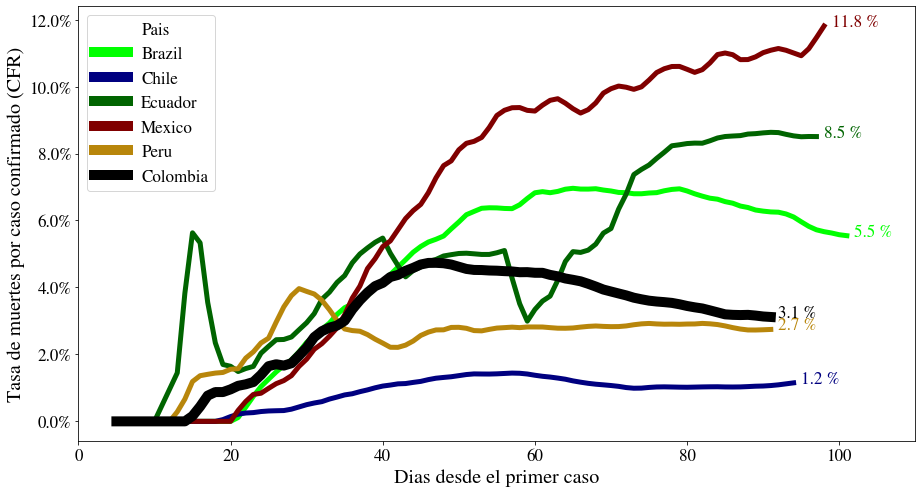

In [14]:
from matplotlib import ticker
#sns.set_palette(sns.color_palette('Accent_r'))

# Figure
fig = plt.figure(figsize=(15,8))
ax = plt.gca()

# Cols to plot
x_col = 'Days Since First Case'
y_col = 'total_deaths'

owid['CFR'] = 100*owid['total_deaths']/owid['total_cases']
owid['CFR'] = owid[['CFR']].rolling(window=3).mean()
# Plots curves
sns.lineplot( x='Days Since First Case'
             ,y='CFR'
             ,data=owid[(owid[x_col]>=5)&owid['iso_code'].isin(['BRA','CHL','MEX','PER','ECU'])]
             ,hue='Pais'
             ,palette=country_palette             
             ,linewidth=5)
sns.lineplot( x='Days Since First Case'
             ,y='CFR'
             ,data=owid[(owid[x_col]>=5)&owid['iso_code'].isin(['COL'])]
             ,label='Colombia'
             ,color='black'
             ,linewidth=10)
# Log scale
#ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())


data = owid.sort_values(by='Days Since First Case')
data_last = data.groupby(['Pais']).agg(['last']).reset_index()
for i, point in data_last.iterrows():
    if (point['iso_code'].values[0] in ['BRA','CHL','MEX','PER','ECU','COL'] ):
        #print(point['Days Since First Case'].values[0],
        #      point['Doubling Time Smoothened'].values[0],
        #      '%.2f' % point['Doubling Time Smoothened'].values[0])
        plt.gca().text(point['Days Since First Case'].values[0]+1,
                        point['CFR'].values[0],
                        str('%.1f' % (point['CFR'].values[0]/1))+' %' ,
                            color=country_palette[point['Pais'].values[0]]  )


# Plots legend
plt.legend(loc='best')

# gets legend
leg = plt.gca().legend()
# Line thicknes in legend
for line in leg.get_lines():
    line.set_linewidth(10)

plt.xlim(0,110)
# Axes labels
plt.xlabel('Dias desde el primer caso')
plt.ylabel('Tasa de muertes por caso confirmado (CFR)')

# Save fig
plt.savefig(f'{VIZ_PATH}/CFR.png')


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


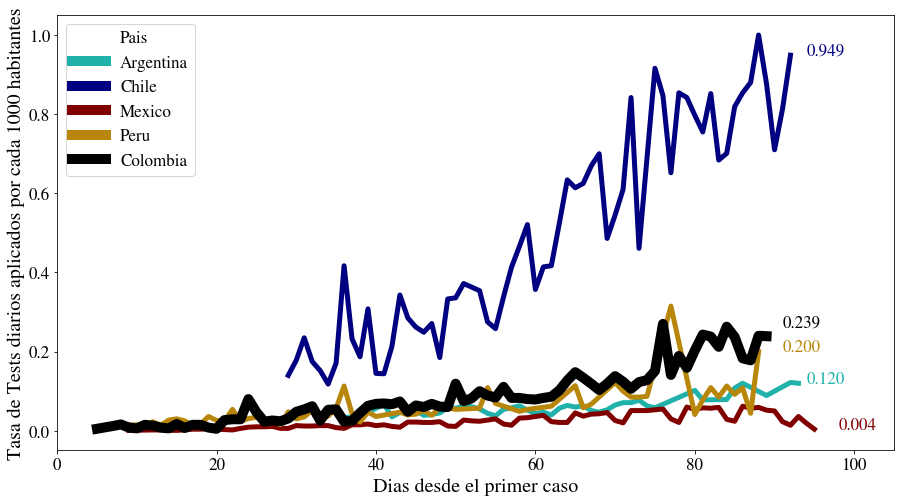

In [23]:
# Figure
fig = plt.figure(figsize=(15,8))
ax = plt.gca()
# Plots curves
sns.lineplot( x='Days Since First Case'
             ,y='new_tests_per_thousand'
             ,data=owid[(owid[x_col]>=5)&owid['iso_code'].isin(['ECU','CHL','MEX','PER','ARG']) & 
                        (owid['new_tests_per_thousand']>0)].
              sort_values(by='Pais')#,ascending=False)
             ,hue='Pais'
             ,palette=country_palette             
             ,linewidth=5)
sns.lineplot( x='Days Since First Case'
             ,y='new_tests_per_thousand'
             ,data=owid[(owid[x_col]>=5)&owid['iso_code'].isin(['COL'])].
              sort_values(by='Pais')#,ascending=False)
             ,color='black'
             ,label='Colombia'
             ,linewidth=10)

data = owid.sort_values(by='Days Since First Case')
data_last = data.groupby(['Pais']).agg(['last']).reset_index()
for i, point in data_last.iterrows():
    if (point['iso_code'].values[0] in ['ECU','CHL','MEX','PER','ARG','COL'] ):
        #print(point['Days Since First Case'].values[0],
        #      point['Doubling Time Smoothened'].values[0],
        #      '%.2f' % point['Doubling Time Smoothened'].values[0])
        if point['Pais'].values[0] in ['Colombia']:
            plt.gca().text(point['Days Since First Case'].values[0],
                            point['new_tests_per_thousand'].values[0]*1.1,
                            str('%.3f' % (point['new_tests_per_thousand'].values[0]/1))+'' ,
                                color=country_palette[point['Pais'].values[0]]  )
        else:
            plt.gca().text(point['Days Since First Case'].values[0],
                            point['new_tests_per_thousand'].values[0],
                            str('%.3f' % (point['new_tests_per_thousand'].values[0]/1))+'' ,
                                color=country_palette[point['Pais'].values[0]]  )


# Plots legend
plt.legend(loc='upper left')

# gets legend
leg = plt.gca().legend(loc='upper left')
# Line thicknes in legend
for line in leg.get_lines():
    line.set_linewidth(10)

# Customize Axes lims
#plt.xlim(min_date,data['date'].max())
# Ticks rotation
# Integer ticks
#plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None))

plt.xlim(0,105)
# Axes labels
plt.xlabel('Dias desde el primer caso')
plt.ylabel('Tasa de Tests diarios aplicados por cada 1000 habitantes')
#plt.xlim(datetime.date(2020,4,1),datetime.date(2020,5,1))
# Save fig
plt.savefig(f'{VIZ_PATH}/Tests por 1000.png')

In [16]:
owid.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'Ratio de Positivos por Test', 'Days Since First Case', 'Pais', 'CFR'],
      dtype='object')

/home/jesus_prada/anaconda3/envs/ml_rappi/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


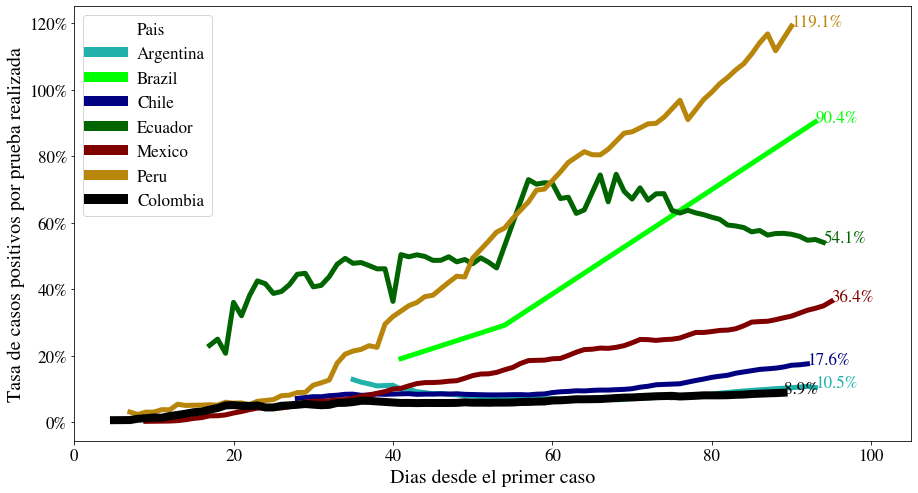

In [17]:
import matplotlib.ticker as mtick

# Figure
fig = plt.figure(figsize=(15,8))
owid['Ratio de Positivos por Test'] = 100*owid['total_cases']/owid['total_tests']
# Plots curves
sns.lineplot( x='Days Since First Case'
             ,y='Ratio de Positivos por Test'
             ,data=owid[(owid[x_col]>=5)&owid['iso_code'].isin(['BRA','CHL','ECU','ARG','PER','MEX'])& 
                        (owid['Ratio de Positivos por Test']>0)]
             ,hue='Pais'
             ,palette=country_palette             
             ,linewidth=5)
sns.lineplot( x='Days Since First Case'
             ,y='Ratio de Positivos por Test'
             ,data=owid[(owid[x_col]>=5)&owid['iso_code'].isin(['COL'])]
             ,color='black'
             ,label='Colombia'
             ,linewidth=8)

data = owid.sort_values(by='Days Since First Case')
data_last = data[(owid['Ratio de Positivos por Test']>0)].groupby(['Pais']).agg(['last']).reset_index()
for i, point in data_last.iterrows():
    if (point['iso_code'].values[0] in ['BRA','CHL','ECU','ARG','COL','PER','MEX'] ):
        #print(point['Days Since First Case'].values[0],
        #      point['Doubling Time Smoothened'].values[0],
        #      '%.2f' % point['Doubling Time Smoothened'].values[0])
        if point['Pais'].values[0] in ['Colombia']:
            plt.gca().text(point['Days Since First Case'].values[0],
                            point['Ratio de Positivos por Test'].values[0]*1,
                            str('%.1f' % (point['Ratio de Positivos por Test'].values[0]/1))+'%' ,
                                color=country_palette[point['Pais'].values[0]]  )
        else:
            plt.gca().text(point['Days Since First Case'].values[0],
                            point['Ratio de Positivos por Test'].values[0],
                            str('%.1f' % (point['Ratio de Positivos por Test'].values[0]/1))+'%' ,
                                color=country_palette[point['Pais'].values[0]]  )
# Plots legend
plt.legend(loc='best')

# gets legend
leg = plt.gca().legend()
# Line thicknes in legend
for line in leg.get_lines():
    line.set_linewidth(10)

# Customize Axes lims
#plt.xlim(min_date,data['date'].max())
# Ticks rotation
# Integer ticks
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None))

# Axes labels
plt.xlim(0,105)

plt.xlabel('Dias desde el primer caso')
plt.ylabel('Tasa de casos positivos por prueba realizada')
#plt.xlim(datetime.date(2020,4,1),datetime.date(2020,5,1))
# Save fig
plt.savefig(f'{VIZ_PATH}/Positivos por test.png')

In [18]:
data = owid.sort_values(by='Days Since First Case')
data_last = data[(owid['Ratio de Positivos por Test']>=0)&
                 (owid['new_tests_per_thousand']>=0)].groupby(['Pais']).agg('last').reset_index()

/home/jesus_prada/anaconda3/envs/ml_rappi/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
data_last['Pais']

0        Argentina
1            Chile
2         Colombia
3            Italy
4           Mexico
5             Peru
6    United States
Name: Pais, dtype: object

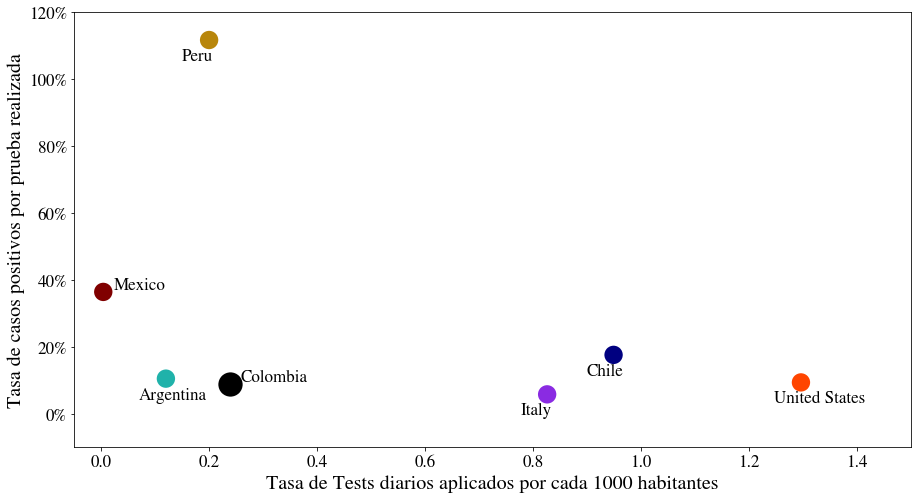

In [20]:
# Figure
fig = plt.figure(figsize=(15,8))

# Calculates the positive case to Test ratio for each country/date
#owid_last['Ratio de Positivos por Test'] = 100*owid_last['total_cases']/owid_last['total_tests']
#owid_last
# Plots curves
pl = sns.scatterplot( x='new_tests_per_thousand'
                ,y='Ratio de Positivos por Test'
                ,data=data_last[~data_last['Pais'].isin(['Colombia'])]
                ,hue='Pais'
                ,palette=country_palette                     
                ,linewidth=4
                ,s=500,legend=False)
p2 = sns.scatterplot( x='new_tests_per_thousand'
                ,y='Ratio de Positivos por Test'
                ,data=data_last[data_last['Pais']=='Colombia']
                ,color='Black'
                ,linewidth=4
                ,s=800,legend=False)

# Plots legend
#plt.legend(loc='best')

# gets legend
#leg = plt.gca().legend()
# Line thicknes in legend
#for line in leg.get_lines():
#    line.set_linewidth(10)

# Customize Axes lims
#plt.xlim(min_date,data['date'].max())
# Ticks rotation
# Integer ticks
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None))

# Axes labels
plt.ylabel('Tasa de casos positivos por prueba realizada')
plt.xlabel('Tasa de Tests diarios aplicados por cada 1000 habitantes')
#plt.xlim(datetime.date(2020,4,1),datetime.date(2020,5,1))
# Save fig
#plt.savefig(f'{VIZ_PATH}/Tests por 1000.png')
ax = plt.gca()
for i, point in data_last.iterrows():
    #print(point)
    if(point['Pais'] in  ['Italy','Chile','Peru','United States','Ecuador','Argentina']):
        ax.text(point['new_tests_per_thousand']-0.05, point['Ratio de Positivos por Test']-6, str(point['Pais']))
    else:
        ax.text(point['new_tests_per_thousand']+0.02, point['Ratio de Positivos por Test']+1, str(point['Pais']))
plt.ylim(-10,120)
plt.xlim(-0.05,1.5)

plt.savefig(f'{VIZ_PATH}/Tests Vs Positive Rate.png')

In [21]:
owid.loc[(~owid['new_tests_per_thousand'].isna())&(owid['Pais'] == 'United States'),['Days Since First Case','new_tests_per_thousand']]

,Days Since First Case,new_tests_per_thousand
21168,113,1.488
21173,118,1.314
21174,119,3.983
21175,120,0.957
21181,126,3.180
21182,127,1.759
21188,133,3.916
21189,134,1.432
21190,135,1.296


In [22]:
owid_last

NameError: name 'owid_last' is not defined